In [19]:
import numpy as np
import re
import math
import os
import pandas as pd
import xml.etree.ElementTree as ET
import pydicom as dicom
import matplotlib.pyplot as plt

from skimage.draw import polygon
from pathlib import Path
from monai.transforms import (MapTransform, Compose, Transposed, ToTensord, LoadImaged,
                              ScaleIntensityd, Resized, CropForegroundd, SpatialPadd, RandCropByLabelClassesd)
from monai.data import Dataset, DataLoader 


In [3]:
class Annotation:
      
  def __init__(self, xml_path, filename, shape):

    self.xml_path = xml_path + filename + '.xml'
    self.mask     = self.create_mask_array(shape)
    self.fill_mask()


  """
  This function creates the proper contour/polygon for each ROI and stores
  the information in the corresponding position of the mask object
  """
  def fill_mask(self):
    if os.path.exists(self.xml_path):
      rois, num_rois   = self.parse_XML(self.xml_path)

      for roi in rois:
        roi_info       = self.get_roi_info(roi)
        r_poly, c_poly = self.create_polygon_lists(self.mask, roi_info["points"])
        rr, cc         = polygon(r_poly, c_poly)
        roi_channel    = self.select_mask_channel(roi_info["roi_type"])
        try:
          self.mask[rr, cc, roi_channel] = 1
        except IndexError:
          print(self.xml_path)


  """
  Inputs:
    -- xml_path: Path to the corresponding xml file
  Outputs:
    -- rois: Array with the ROI objects
    -- num_of_rois: Number of ROIs 
  """
  def parse_XML(self, xml_path):
    tree        = ET.parse(xml_path)
    root        = tree.getroot()       # The root of the XML file
    data        = root[0][1]           # The essential info
    rois        = data[0][5]           # Array containing the ROI objects
    num_of_rois = int(data[0][3].text) # Number of ROI objects

    return rois, num_of_rois


  """
  Inputs:
    -- img_shape: The preferred shape of the mask to be created
  Outputs:
    -- 3-dimensional numpy array of type uint8 
  """
  def create_mask_array(self,img_shape):
    return np.zeros((img_shape[0], img_shape[1], 3), dtype = np.uint8)

  def get_roi_info(self, roi):
    roi_info      = {
      "points":        roi[21],           # Array containing the points of a ROI
      "num_of_points": int(roi[17].text), # Number of points of the area
      "roi_index":     int(roi[7].text),  # Identifier of the ROI
      "roi_type":      roi[15].text       # (Mass, Calcification, other)
    }

    return roi_info



  """
  Inputs:
    -- mask: numpy object of the mask
    -- points: x-y coordinates of a ROI's points
  Outputs:
    -- r_poly: array containing the x-axis coordinates
    -- c_poly: array containing the y-axis coordinates
  """
  def create_polygon_lists(self, mask, points):
    mask_width  = mask.shape[0]
    mask_height = mask.shape[1]
    r_poly      = np.array([])
    c_poly      = np.array([])
    roi_img     = np.zeros((mask_width, mask_height), dtype=np.uint8)

    for point in points:

      temp_tuple = point.text[1:-1].split(",")
      y          = int(math.trunc(float(temp_tuple[0]))) 
      x          = int(math.trunc(float(temp_tuple[1])))
      r_poly     = np.append(r_poly, x)
      c_poly     = np.append(c_poly, y)

    return r_poly, c_poly


  """
  Input:
    -- roi_type: The type of a specific ROI, extracted from the XML file
  Output:
    -- roi_channel: The type of the ROI defines the integer value of this var
  """
  def select_mask_channel(self, roi_type):
    roi_ch = 2
    if roi_type == "Mass":
      roi_ch = 0
    elif roi_type == "Calcification":
      roi_ch = 1
    return roi_ch

In [14]:
# Convert XML-based annotations to numpy arrays
workindir = Path(os.getcwd()) # Path to the working directory, where the AllDICOMs and AllXML are stored

case_path = workindir.joinpath('AllDICOMs')
mask_path = workindir.joinpath('AllXML')

masks = sorted([f for f in mask_path.glob('*')])
case_ids = sorted([f.stem for f in masks])

cases = sorted([f for f in case_path.glob('*') if str(f).endswith('.dcm') and f.stem.split('_')[0] in case_ids])
dicoms = sorted([f.stem for f in case_path.glob('*') if str(f).endswith('.dcm') and f.stem.split('_')[0] in case_ids])

if not os.path.exists(workindir.joinpath('AllMasks')):
    os.mkdir(workindir.joinpath('AllMasks'))

for case_id, dicom_case in zip(case_ids, dicoms):
    print(case_id)

    # Read dicom file
    dcm = dicom.dcmread(str(case_path) + '\\' + dicom_case + '.dcm')
    img = dcm.pixel_array

    # Get Annoation 
    a = Annotation(str(mask_path) + '\\', case_id, img.shape).mask[:,:,0] # channel 0 is the lession
    np.save(f'./AllMasks/{case_id}.npy', a)

In [15]:
mask_path = workindir.joinpath('AllMasks')

df = pd.read_csv(workindir.joinpath('lesion_on_cases.csv'))
df = df[df['lesion'] == 1]
df['case'] = df['case'].astype(str)

cases = sorted([f for f in case_path.glob('*')])
masks = sorted([f for f in mask_path.glob('*')])

image_files = sorted([f for f in cases if f.stem.split('_')[0] in [k.stem for k in masks] and f.stem.split('_')[0] in df['case'].tolist()])
mask_files = sorted([f for f in masks if f.stem in df['case'].tolist()])

datadict = [{'image': im, 'mask': m} for im, m in zip(image_files, mask_files)]

In [31]:
datadict = datadict[:10]
datadict[0]

{'image': WindowsPath('D:/Users/kkouko0/DATASETS/INBreast/INbreast Release 1.0/AllDICOMs/20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm'),
 'mask': WindowsPath('D:/Users/kkouko0/DATASETS/INBreast/INbreast Release 1.0/AllMasks/20586908.npy')}

In [17]:
class ConvertINBreastLesionToMultiChannelMaskd(MapTransform):
    """
        Convert multi-label singe-channel mask to multiple-channel one-hot encoded 
    """
    def __call__(self, data):
        d = dict(data)
        
        background = d['mask'][0] == 0
        lesion = d['mask'][0] == 1

        d['segmentation'] = np.stack((background, lesion), axis=0)

        return d

In [32]:
transforms = Compose([
    # # Load and preprocess
    LoadImaged(keys=['image'], ensure_channel_first=True),
    LoadImaged(keys=['mask'], ensure_channel_first=True),
    Transposed(keys=['image'], indices=[0, 2, 1]),
    ScaleIntensityd(keys=['image'], minv=0, maxv=1),

    # Resize
    Resized(keys=['image'], spatial_size=[2048, 2048]),
    Resized(keys=['mask'], spatial_size=[2048, 2048], mode='nearest'),

    # Crop foreground
    CropForegroundd(keys=['image', 'mask'], source_key='image'),
    SpatialPadd(keys=['image', 'mask'], spatial_size=[1024, 512]),
    SpatialPadd(keys=['mask'], spatial_size=[1024, 512]),
    ConvertINBreastLesionToMultiChannelMaskd(keys=['mask']),
    RandCropByLabelClassesd(keys=['image', 'mask', 'segmentation'], label_key='segmentation', spatial_size=[512, 512],
                            num_classes=2, num_samples=1, ratios=[0, 1]),

    ToTensord(keys=['image', 'mask', 'segmentation'])
])

dataset = Dataset(data=datadict, transform=transforms)

In [33]:
train_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [34]:
sample = next(iter(train_loader))

In [35]:
sample.keys()

dict_keys(['image', 'mask', 'image_meta_dict', 'mask_meta_dict', 'foreground_start_coord', 'foreground_end_coord', 'segmentation'])

In [36]:
sample['image'].shape, sample['mask'].shape, sample['segmentation'].shape

((1, 1, 512, 512), (1, 1, 512, 512), (1, 2, 512, 512))

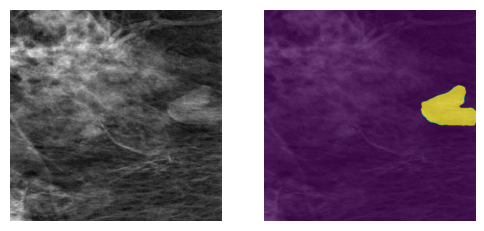

In [37]:
fig, ax = plt.subplots(1,2,figsize=(6,12))
ax[0].imshow(sample['image'][0,0].numpy(), cmap="gray")
ax[0].axis('off')

ax[1].imshow(sample['image'][0,0].numpy(),cmap='gray')
ax[1].imshow(sample['segmentation'][0,1].numpy(), alpha=0.7)
ax[1].axis('off')
plt.show()

In [38]:
from monai.networks.nets import UNet
model = UNet(spatial_dims=2, in_channels=1, out_channels=2,
             kernel_size=3, up_kernel_size=3,
             channels=(32, 64, 128, 256, 512, 1024),
             strides=(2, 2, 2, 2, 2), num_res_units=3,
             norm='instance', dropout=.4)
model.cuda()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.4, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.4, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_st

In [39]:
import torch
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import EnsureType, AsDiscrete
from monai.data.utils import decollate_batch

optimizer = torch.optim.Adam(model.parameters(), 1e-4)
criterion = DiceLoss(softmax=True, include_background=True)
metric = DiceMetric(include_background=False, reduction="mean")

post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType()])

In [40]:
for epoch in range(2):
    for batch_data in train_loader:
        inputs, labels = batch_data['image'].to(device='cuda'), batch_data['segmentation'].to(device='cuda')

        optimizer.zero_grad()
        outputs = model(inputs)

        loss_ep = criterion(outputs, labels)
        loss_ep.backward()

        _outputs = [post_pred(i) for i in decollate_batch(outputs)]
        _labels = [post_label(i) for i in decollate_batch(labels)]

        optimizer.step()
        metric(y_pred=_outputs, y=_labels)
    metric_ep = metric.aggregate().item()
    print(f'Epoch {epoch} of 10 with Train loss {loss_ep.item()}')
    print(f'Epoch {epoch} of 10 with Train metric {metric_ep}')
    print(f'-------------- Finished epoch {epoch} -------------')

Epoch 0 of 10 with Train loss 0.6242179870605469
Epoch 0 of 10 with Train metric 0.15179438889026642
-------------- Finished epoch 0 -------------
Epoch 1 of 10 with Train loss 0.6183503866195679
Epoch 1 of 10 with Train metric 0.15090417861938477
-------------- Finished epoch 1 -------------
